In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [2]:
def cluster_variance(n, x):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
    return variances,K,n

In [3]:
ds = xr.open_dataset(f"challenge_1min_numerical_EP.nc")

# ds = ds.where((ds.latitude > 0) & (ds.latitude < 20) & (ds.longitude > 100) & (ds.longitude < 160), drop=True)  # bbox = [100, -15, 160, 30],
ds = ds.where((ds.latitude > 0) & (ds.latitude < 20) & (ds.longitude > -160) & (ds.longitude < -100), drop=True)  # bbox = [-160, -10,-100, 20],


sh: 1: getfattr: not found


In [4]:
x = ds.drop_vars(['latitude','longitude']).to_array().transpose("time", "variable").values
# x = ds.to_array().transpose("time", "variable").values

x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
x

array([[0.00000000e+00, 1.13414934e-05, 1.19200074e-01, 7.78431978e-02],
       [0.00000000e+00, 6.08013767e-03, 1.99288558e-01, 1.61866720e-02],
       [0.00000000e+00, 5.97706354e-05, 1.24708356e-01, 5.72241542e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.53601588e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.30546898e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(1493, 4))

Initialization complete
Iteration 0, inertia 145.38850548607417.
Iteration 1, inertia 100.56721529388125.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 91.77187842672693.
Iteration 1, inertia 65.67010862702548.
Iteration 2, inertia 65.0654086935306.
Iteration 3, inertia 64.82771643915227.
Iteration 4, inertia 64.66227515481715.
Iteration 5, inertia 64.59209658108296.
Iteration 6, inertia 64.56747294075987.
Iteration 7, inertia 64.55350963318241.
Iteration 8, inertia 64.55201632820602.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 68.61521084869783.
Iteration 1, inertia 52.230073027733944.
Iteration 2, inertia 49.79389431083895.
Iteration 3, inertia 47.959577442213615.
Iteration 4, inertia 46.99141676949218.
Iteration 5, inertia 46.66774206840976.
Iteration 6, inertia 46.410486274352266.
Iteration 7, inertia 46.28163551116771.
Iteration 8, inertia 46.22500514057471.
Iteration 9, inertia 46.21036341

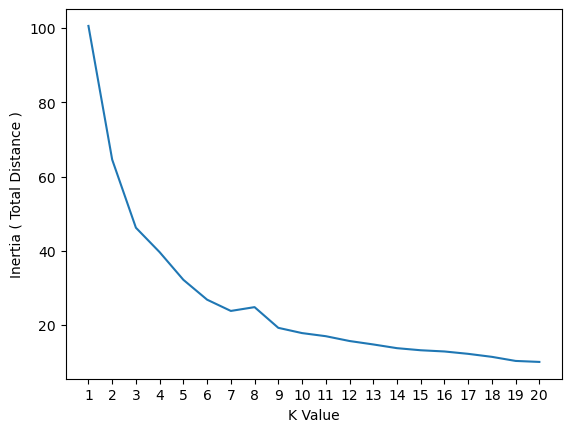

In [5]:
variances,K,n=cluster_variance(20, x)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

In [6]:
ds

<xarray.Dataset> Size: 66kB
Dimensions:                          (time: 1493)
Coordinates:
  * time                             (time) datetime64[ns] 12kB 2025-06-12T09...
Data variables:
    latitude                         (time) float64 12kB 3.268 7.154 ... 1.683
    longitude                        (time) float64 12kB -111.1 ... -147.1
    land_flag                        (time) float64 12kB 0.0 0.0 0.0 ... 0.0 0.0
    ice_water_path                   (time) float32 6kB 1.36e-05 ... 0.0
    liquid_water_path                (time) float32 6kB 0.04835 0.08083 ... 0.0
    aerosol_optical_thickness_355nm  (time) float32 6kB 0.2941 0.06116 ... 0.0

In [7]:
k = 5

# Applichiamo K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(x)


In [8]:
vars = {
    # 'lat': 0,
    # 'lon': 1,
    'landf' : 0 ,
    'iwp': 1,
    'lwp': 2,
    'aot': 3
}

In [9]:
def plot_kmeans(x, varX, varY, ax=None):

    if not ax:
        fig, ax = plt.subplots()
    
    # Visualizziamo i dati colorati in base ai cluster trovati
    ax.scatter(x[:, vars[varX]], x[:, vars[varY]], c=y_kmeans, s=10, cmap='jet', alpha=0.5)  #'viridis')
    
    # Mostriamo anche i centroidi
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, vars[varX]], centers[:,  vars[varY]], c='red', s=50, alpha=0.75, marker='X', label='Centroids')
    for i in np.arange(1,6):
        ax.text(centers[(i-1), vars[varX]]*1.1, centers[(i-1),  vars[varY]]*1.1, s=str(i), c='red')
    
    ax.set_title("K-Means clustering")
    ax.set_xlabel(varX)
    ax.set_ylabel(varY)
    ax.legend()


In [10]:
[str(i) for i in np.arange(1,6)]

['1', '2', '3', '4', '5']

In [11]:
kmeans.cluster_centers_

array([[0.01148382, 0.10911137, 0.37459714, 0.10519264],
       [0.00388471, 0.00741383, 0.04268621, 0.04727282],
       [0.04089813, 0.0346817 , 0.38415908, 0.51469735],
       [0.04692308, 0.57008085, 0.33823599, 0.05168156],
       [0.00657995, 0.00786332, 0.12143705, 0.2519791 ]])

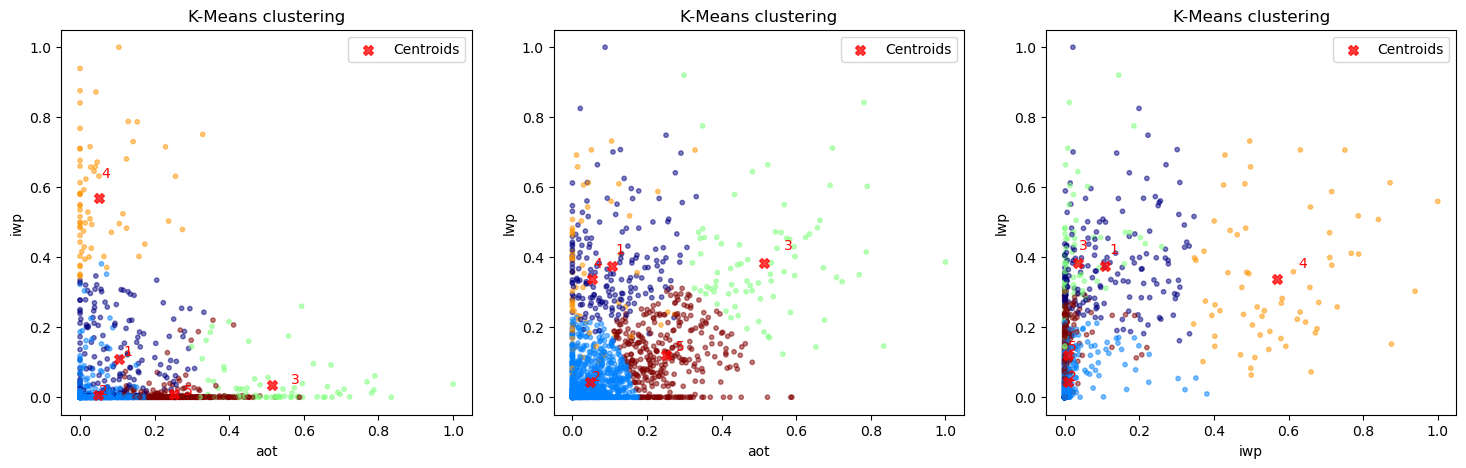

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY, ax=axes[0])

varX='aot'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[1])


varX='iwp'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[2])

(0.0, 0.25)

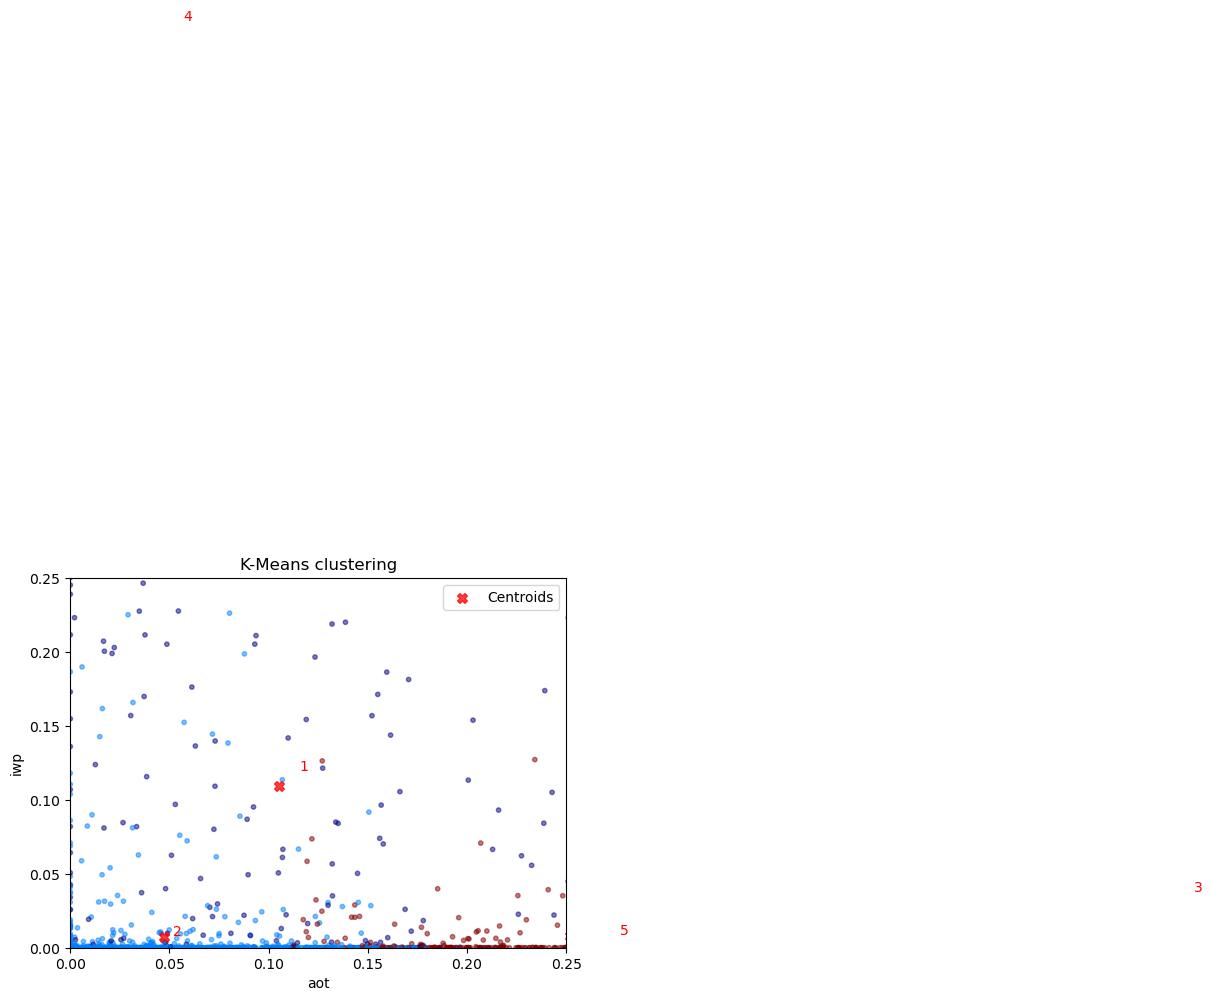

In [13]:
varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY)
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

### Classes we were expepcting:

- Cluster 4: Aerosol with no clouds

- Cluster 3: Ice and water with no transparency (ATLID is not seeing aerosol)

Let's see the other three


In [14]:
# select only clusters 1, 2 and 5

In [15]:
np.unique(y_kmeans)

array([0, 1, 2, 3, 4], dtype=int32)

In [16]:
indices = np.where((y_kmeans == 0) | (y_kmeans == 1) | (y_kmeans == 4))[0]

In [17]:
(vars['iwp'], vars['aot'])

(1, 3)

In [18]:
a = x[indices, 3]
b = x[indices, 1]

m, q = np.polyfit(a, b, deg=1)

b_pred = q + m * a #+ n *a**2

print(q, m, n)


0.022213077283384713 -0.010238282193828111 20


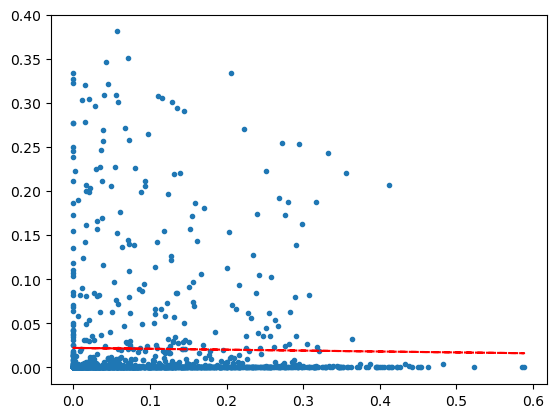

In [19]:
varX='aot'
varY='iwp'

# plot_kmeans(x, varX, varY)
# plt.xlim(0, 0.25)
# plt.ylim(0, 0.25)

plt.plot(a, b, '.')
plt.plot(a, b_pred, 'r--')

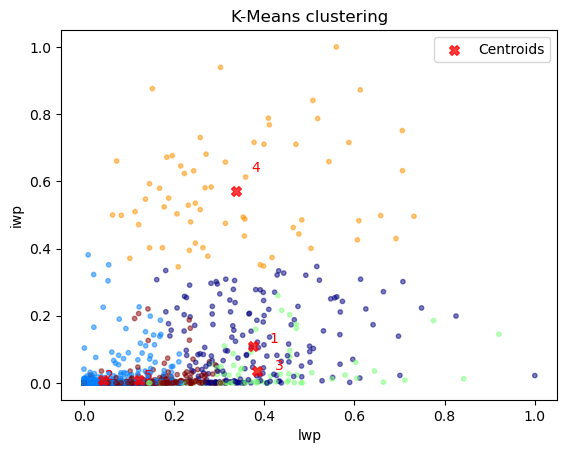

In [20]:
varX='lwp'
varY='iwp'

plot_kmeans(x, varX, varY)

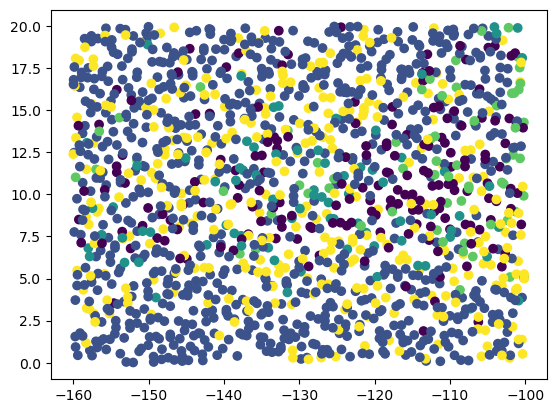

In [21]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='viridis')

Text(0, 0.5, 'latitude')

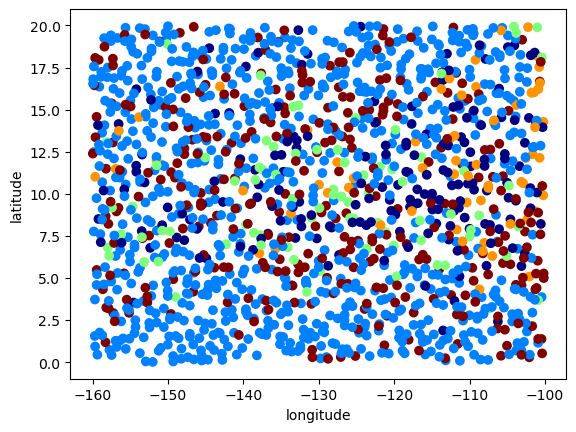

In [22]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='jet')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [23]:
# TODO Let's see how the AC__TC labels pair up with the clusters